In [1]:
from functions import *
import re
import networkx as nx
from dask.distributed import Client
from nltk.util import ngrams
from dask import delayed
from dask import bag as db
from dask import compute
from nltk.util import ngrams
from sklearn.feature_extraction.text import HashingVectorizer , TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
import dask_ml.feature_extraction.text as dask_text
import dask
from itertools import chain
from dask import bag as db
from dask import dataframe as dd
from itertools import chain
import pandas as pd
import dask.array as da
import itertools
from dask.distributed import get_client
from umap import UMAP
import hdbscan
import time
from scipy.sparse import csr_matrix
import seaborn as sns

import matplotlib.pyplot as plt
from glob import glob
from nltk.util import ngrams
import sys
import cython
%load_ext cython

In [2]:
%%cython
# -a
import numpy as np   
import scipy.sparse as sp

from libc.stdlib cimport malloc, free
from libc.stdio cimport fopen, fclose, FILE, EOF, fgetc, feof
from cython.parallel import prange
cimport numpy as cnp
cimport cython

cdef int char2int(char chars) nogil:
    if chars == 65: return 0
    elif chars == 67: return 1
    elif chars == 71: return 2
    elif chars == 84: return 3
    return -1

cdef int invchar2int(char chars) nogil:
    if chars == 65: return 3
    elif chars == 67: return 2
    elif chars == 71: return 1
    elif chars == 84: return 0
    return -1


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)
cdef cykmerarray(str filename, int klen, unsigned long max_size = -1): ##unsigned long is up to 32bp cnp.uint16_t[:]
    """Efficiently read in a file"""
    cdef FILE *fp = NULL # create a file pointer
    fp = fopen(filename.encode(encoding='utf-8'), "rb")
    if fp == NULL:
        raise FileNotFoundError(2, "No such file or directory: '%s'" % filename)
    # file parsing variables
    cdef unsigned long array_size = 4**klen - 4**(klen//2)
    cdef unsigned long fw_div = 4**(klen-1)
    
    if max_size > 0 and max_size < array_size:
        array_size = max_size
    
    cdef char c 
    cdef int i
    cdef int is_line = 1 
    cdef int window_pos = 0
    cdef bytes pywindow 
    cdef unsigned long fw_num = 0
    cdef unsigned long rv_num = 0
    #cdef list col = []
    cdef cnp.ndarray[cnp.int16_t, ndim=1] result = np.zeros((array_size), dtype = np.int16)
    
    #cdef int stopearly = 0
    # bypass the gil
    with nogil:
        while 1 :
            c = fgetc(fp)
            if feof(fp): break
            if c == 78: window_pos = 0
            elif c == 10: 
                is_line += 1
                if is_line > 4: is_line= 1
                window_pos = 0
            elif is_line == 2: 
                fw_num = fw_num*4 + char2int(c)
                rv_num = invchar2int(c)*(4**window_pos) + rv_num
                window_pos += 1
                if window_pos == klen: 
                    if fw_num < rv_num: result[fw_num%max_size] += 1
                    else: result[rv_num%max_size] += 1
                    fw_num %= fw_div
                    rv_num //= 4
                    window_pos -= 1
    # close the file
    fclose(fp)
    return result

cdef list getK(char *string, int klen):
    cdef unsigned long fw_num = 0
    cdef unsigned long rv_num = 0
    cdef unsigned long fw_div = 4**(klen-1)
    cdef window_pos = 0
    cdef char c
    ret = []
    for c in string:
        if char2int(c) == -1: window_pos = 0
        else:
            fw_num = fw_num*4 + char2int(c)
            rv_num = invchar2int(c)*(4**window_pos) + rv_num
            window_pos += 1
            if window_pos == klen: 
                    if fw_num < rv_num: ret.append(fw_num)
                    else: ret.append(rv_num)
                    fw_num %= fw_div
                    rv_num //= 4
                    window_pos -= 1
    return ret

def pygetK(string, klen):
    return getK(string.encode(encoding='ascii'), klen)
    

def cyhashSMARTVEC(filenames = [], int klen = 13, max_size = -1):
    if max_size > 1e9: 
        print('this will use more than 1 gb per file')
        return -1
    cdef long size = 4**klen - 4**(klen//2)  #cdef long long 
    if max_size > 0 and max_size < size:
        size = max_size
    cdef int corpus_size = len(filenames)
    for  num,name  in enumerate(filenames):
        if num == 0: ret = sp.csr_matrix(cykmerarray(name, klen, size))
        else: ret = sp.vstack((ret, cykmerarray(name, klen, size)))
    ret._meta = sp.eye(0, dtype = np.int16 ,format="csr")
    return ret




In [3]:
lis = sorted(glob('data/*.txt'))
from dask.distributed import Client
client = Client(processes = False)#
client

Client Scheduler: inproc://192.168.0.106/5613/1 Dashboard: http://192.168.0.106:8787/status,Cluster Workers: 1 Cores: 4 Memory: 16.66 GB


In [34]:
%time B = cyhashSMARTVEC(['data/001genome.txt'], klen = 15, max_size = 1e7)


CPU times: user 734 ms, sys: 15.4 ms, total: 750 ms
Wall time: 749 ms


In [28]:
B.eliminate_zeros()

0.9999990463256836

In [ ]:
%time B = cyhashSMARTVEC(['data2/DC4_010_R1.fastq'], klen = 15, max_size = 1e7)


In [4]:
b = db.from_sequence(sorted(glob('data/*genome.txt'))[:])
bag2 = b.map_partitions(cyhashSMARTVEC, klen = 14, max_size = 1e7 )
objs = bag2.to_delayed()
arrs = [da.from_delayed(obj, (1, 1e7), str) for obj in objs] #np.nan
ret = da.concatenate(arrs, axis=0)

In [5]:
%time X = ret.compute()

CPU times: user 1min 21s, sys: 1.04 s, total: 1min 22s
Wall time: 24.3 s


In [60]:
import hashvec as hv
import hdbscan


/home/thiagoms/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components
/home/thiagoms/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


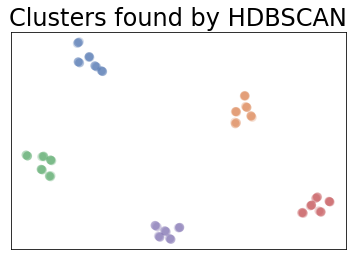

In [61]:
hv.plot_clusters(UMAP().fit_transform(X), hdbscan.HDBSCAN, (), {'min_cluster_size':15})

In [63]:
sp.save_npz('spMatrix_gen',X ,compressed = True)

In [15]:
bd = db.from_sequence(sorted(glob('data/*genome.txt'))[:]).to_dataframe()


In [16]:
A = bd.map_partitions(cyhashSMARTVEC, klen = 14, max_size = 1e7)
#A._meta = sp.eye(0, format="csr")
#b = A.compute()

ValueError: Metadata inference failed in `cyhashSMARTVEC`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
TypeError('Expected unicode, got int')

Traceback:
---------
  File "/home/thiagoms/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py", line 172, in raise_on_meta_error
    yield
  File "/home/thiagoms/anaconda3/lib/python3.7/site-packages/dask/dataframe/core.py", line 4938, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "_cython_magic_92b5f7a36dd96da72ae7c51c419e1ead.pyx", line 110, in _cython_magic_92b5f7a36dd96da72ae7c51c419e1ead.cyhashSMARTVEC


<0x0 sparse matrix of type '<class 'numpy.int16'>'
	with 0 stored elements in Compressed Sparse Row format>

In [ ]:
import vaex

klen = 14
fw_division = 4**(14-1)

In [ ]:
df = vaex.read_csv_and_convert('data/000genome.txt', columns = 'text')
df.text

In [ ]:
df.text.apply(lambda x: pygetK(x, 20))

In [ ]:
 vaex.read_csv?

In [ ]:
import itertools

In [1]:
pygetK('ATAGCTACGTACGTAQWRETCGNNNTAasdfsdvcds21341234CNNNGATCA', 3)

NameError: name 'pygetK' is not defined

In [2]:
import dask.bag as db

In [ ]:
%%cython -a
import numpy as np   
import scipy.sparse as sp

from libc.stdlib cimport malloc, free
from libc.stdio cimport fopen, fclose, FILE, EOF, fgetc, feof
from cython.parallel import prange
cimport numpy as cnp
cimport cython

cdef int char2int(char chars) nogil:
    if chars == 65: return 0
    elif chars == 67: return 1
    elif chars == 71: return 2
    elif chars == 84: return 3
    return -1

cdef int invchar2int(char chars) nogil:
    if chars == 65: return 3
    elif chars == 67: return 2
    elif chars == 71: return 1
    elif chars == 84: return 0
    return -1


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)
cdef cykmerarray(str filename, int klen, unsigned long max_size = -1): ##unsigned long is up to 32bp cnp.uint16_t[:]
    """Efficiently read in a file"""
    cdef FILE *fp = NULL # create a file pointer
    fp = fopen(filename.encode(encoding='utf-8'), "rb")
    if fp == NULL:
        raise FileNotFoundError(2, "No such file or directory: '%s'" % filename)
    # file parsing variables
    cdef unsigned long array_size = 4**klen - 4**(klen//2)
    cdef unsigned long fw_div = 4**(klen-1)
    
    if max_size > 0 and max_size < array_size:
        array_size = max_size
    
    cdef char c 
    cdef int i
    cdef int is_line = 1 
    cdef int window_pos = 0
    cdef bytes pywindow 
    cdef unsigned long fw_num = 0
    cdef unsigned long rv_num = 0
    #cdef list col = []
    cdef cnp.ndarray[cnp.int16_t, ndim=1] result = np.zeros((array_size), dtype = np.int16)
    
    #cdef int stopearly = 0
    # bypass the gil
    with nogil:
        while 1 :
            c = fgetc(fp)
            if feof(fp): break
            if c == 78: window_pos = 0
            elif c == 10: 
                is_line += 1
                if is_line > 4: is_line= 1
                window_pos = 0
            elif is_line == 2: 
                fw_num = fw_num*4 + char2int(c)
                rv_num = invchar2int(c)*(4**window_pos) + rv_num
                window_pos += 1
                if window_pos == klen: 
                    if fw_num < rv_num: result[fw_num%max_size] += 1
                    else: result[rv_num%max_size] += 1
                    fw_num %= fw_div
                    rv_num //= 4
                    window_pos -= 1
    # close the file
    fclose(fp)
    return result

cdef list getK(char *string, int klen):
    cdef unsigned long fw_num = 0
    cdef unsigned long rv_num = 0
    cdef unsigned long fw_div = 4**(klen-1)
    cdef window_pos = 0
    cdef char c
    ret = []
    for c in string:
        if char2int(c) == -1: window_pos = 0
        else:
            fw_num = fw_num*4 + char2int(c)
            rv_num = invchar2int(c)*(4**window_pos) + rv_num
            window_pos += 1
            if window_pos == klen: 
                    if fw_num < rv_num: ret.append(fw_num)
                    else: ret.append(rv_num)
                    fw_num %= fw_div
                    rv_num //= 4
                    window_pos -= 1
    return ret

def pygetK(string, klen):
    return getK(string.encode(encoding='ascii'), klen)
    

def cyhashSMARTVEC(filenames = [], int klen = 13, max_size = -1):
    if max_size > 1e9: 
        print('this will use more than 1 gb per file')
        return -1
    cdef long size = 4**klen - 4**(klen//2)  #cdef long long 
    if max_size > 0 and max_size < size:
        size = max_size
    cdef int corpus_size = len(filenames)
    for  num,name  in enumerate(filenames):
        if num == 0: ret = sp.csr_matrix(cykmerarray(name, klen, size))
        else: ret = sp.vstack((ret, cykmerarray(name, klen, size)))
    return ret


## trying with dok matrix SLOOOOOOOWWWW

In [40]:
%%cython -a
import numpy as np   
import scipy.sparse as sp

from libc.stdlib cimport malloc, free
from libc.stdio cimport fopen, fclose, FILE, EOF, fgetc, feof
from cython.parallel import prange
cimport numpy as cnp
cimport cython

cdef int char2int(char chars) nogil:
    if chars == 65: return 0
    elif chars == 67: return 1
    elif chars == 71: return 2
    elif chars == 84: return 3
    return -1

cdef int invchar2int(char chars) nogil:
    if chars == 65: return 3
    elif chars == 67: return 2
    elif chars == 71: return 1
    elif chars == 84: return 0
    return -1


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)
cdef cyDOK(str filename, int klen, unsigned long max_size = -1): ##unsigned long is up to 32bp cnp.uint16_t[:]
    cdef FILE *fp = NULL # create a file pointer
    fp = fopen(filename.encode(encoding='utf-8'), "rb")
    if fp == NULL:
        raise FileNotFoundError(2, "No such file or directory: '%s'" % filename)
    # file parsing variables
    cdef unsigned long array_size = 4**klen - 4**(klen//2)
    cdef unsigned long fw_div = 4**(klen-1)
    
    if max_size > 0 and max_size < array_size:
        array_size = max_size
    
    cdef char c 
    cdef int i
    cdef int is_line = 1 
    cdef int window_pos = 0
    cdef bytes pywindow 
    cdef unsigned long fw_num = 0
    cdef unsigned long rv_num = 0
    S = sp.dok_matrix((max_size,1), dtype= np.int16)
    while 1 :
        c = fgetc(fp)
        if feof(fp): break
        if c == 78: window_pos = 0
        elif c == 10: 
            is_line += 1
            if is_line > 4: is_line= 1
            window_pos = 0
        elif is_line == 2: 
            fw_num = fw_num*4 + char2int(c)
            rv_num = invchar2int(c)*(4**window_pos) + rv_num
            window_pos += 1
            if window_pos == klen: 
                if fw_num < rv_num: S[fw_num%max_size, 0] += 1
                else: S[rv_num%max_size, 0] += 1
                fw_num %= fw_div
                rv_num //= 4
                window_pos -= 1
    # close the file
    fclose(fp)
    return S.tocsr()


def cyhashDOKVEC(filenames = [], int klen = 13, max_size = -1):
    if max_size > 1e9: 
        print('this will use more than 1 gb per file')
        return -1
    cdef long size = 4**klen - 4**(klen//2)  #cdef long long 
    if max_size > 0 and max_size < size:
        size = max_size
    cdef int corpus_size = len(filenames)
    for  num,name  in enumerate(filenames):
        if num == 0: ret = cyDOK(name, klen, size)
        else: ret = sp.vstack((ret, cyDOK(name, klen, size)))
    return ret

In [42]:
%time B = cyhashDOKVEC(['data/000genome.txt'], klen = 15, max_size = 1e9)


CPU times: user 1min 20s, sys: 619 ms, total: 1min 21s
Wall time: 1min 21s


In [37]:
S.tocoo()

<10x1 sparse matrix of type '<class 'numpy.int16'>'
	with 2 stored elements in COOrdinate format>

In [34]:
S[2,0] += 1
S[2,0]

3

# trying with COO matrix

In [9]:
a = array.array('i')

In [11]:
%%cython -a
import numpy as np   
import scipy.sparse as sp
from array import array

from libc.stdlib cimport malloc, free
from libc.stdio cimport fopen, fclose, FILE, EOF, fgetc, feof
from cython.parallel import prange
cimport numpy as cnp
cimport cython

cdef int char2int(char chars) nogil:
    if chars == 65: return 0
    elif chars == 67: return 1
    elif chars == 71: return 2
    elif chars == 84: return 3
    return -1

cdef int invchar2int(char chars) nogil:
    if chars == 65: return 3
    elif chars == 67: return 2
    elif chars == 71: return 1
    elif chars == 84: return 0
    return -1


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)
cdef cykmerarray(str filename, int klen, unsigned long max_size = -1): ##unsigned long is up to 32bp cnp.uint16_t[:]
    """Efficiently read in a file"""
    cdef FILE *fp = NULL # create a file pointer
    fp = fopen(filename.encode(encoding='utf-8'), "rb")
    if fp == NULL:
        raise FileNotFoundError(2, "No such file or directory: '%s'" % filename)
    # file parsing variables
    cdef unsigned long array_size = 4**klen - 4**(klen//2)
    cdef unsigned long fw_div = 4**(klen-1)
    
    if max_size > 0 and max_size < array_size:
        array_size = max_size
    
    cdef char c 
    cdef int i
    cdef int is_line = 1 
    cdef int window_pos = 0
    cdef bytes pywindow 
    cdef unsigned long fw_num = 0
    cdef unsigned long rv_num = 0
    cdef list col = []
    
    #cdef int stopearly = 0
    # bypass the gil
    while 1 :
        c = fgetc(fp)
        if feof(fp): break
        if c == 78: window_pos = 0
        elif c == 10: 
            is_line += 1
            if is_line > 4: is_line= 1
            window_pos = 0
        elif is_line == 2: 
            fw_num = fw_num*4 + char2int(c)
            rv_num = invchar2int(c)*(4**window_pos) + rv_num
            window_pos += 1
            if window_pos == klen: 
                if fw_num < rv_num: result[fw_num%max_size] += 1
                else: result[rv_num%max_size] += 1
                fw_num %= fw_div
                rv_num //= 4
                window_pos -= 1
    # close the file
    fclose(fp)
    return result


In [15]:
a.append(1)

array('i')

In [16]:
a

array('i', [0, 1])